In [1]:
import numpy
import sys
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import layers

2023-11-10 12:38:16.727118: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 12:38:16.727147: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 12:38:16.727180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 12:38:16.734601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Step 1: Check for GPUs and setup multiGPUs on tensorflow 
1. GPU checking with nvidia-smi
2. use of multiGPUs with tensorflow through distribute.MirroredStrategy function

In [2]:
#Checking for available GPUs 
!nvidia-smi

Fri Nov 10 12:38:18 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1060        Off | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P2              27W /  88W |      6MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
#Strategy for MultiGPUs
multiGPUs=tensorflow.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2023-11-10 12:38:18.274977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 12:38:18.280423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 12:38:18.280601: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Step 2: Data analsysis - reading, cleaning, preparing and understanding of dataset
1. Importing data, data is in form of npy (numpy matrix). With npy form, data loads and processing faster than excel and other matrices types.
2. Data convert to panda dataframe. With panda its easiest to analyze data
3. Analysis-reading of dataset:
       check the size,
       present the first data elements
       check the shape of the data,
       descibe the data (tendency, dispersion through max, min, mean and std of data values as well the type of the values)
4. Cleaning dataset:
    checking for missing values, checking for NA values, checking and fixing invalid values
5. Understanding the structure of the data through seaborn and matplotlib

In [4]:
#load npy data
numpy.set_printoptions(threshold=sys.maxsize)
originalDataset=numpy.load('eICU_age.npy')
#convert our npy dataset to panda dataframe for easy process
originalData= pandas.DataFrame(originalDataset)

In [5]:
#data size contains 2520 elements
originalData.size

2520

In [6]:
#presentation of the fist 5 elements of our dataset
originalData.head()

,age
0,87
1,87
2,76
3,34
4,61


In [7]:
#observation of the data size and features (dataset consists of 1 feature, age and in total 2520 ages of patiens)
originalData.shape

(2520, 1)

In [8]:
#descibe the data (tendency, dispersion through max, min, mean and std of data values as well the type        of the values
#we can observe that the majority of our dataset has mean age 63 years, min age 15 and max 90 years. 
#Also, the std = 17.7, that means that the data aren't spread out.
originalData.describe()

,age
count,2520.000000
mean,63.284524
std,17.725186
min,15.000000
25%,53.000000
50%,66.000000
75%,77.000000
max,90.000000


In [9]:
#observeation of the type for each feature of our dataset (the age has 2520 entries and its type int8, each entry is 10bytes
originalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     2520 non-null   int8 
dtypes: int8(1)
memory usage: 2.6 KB


In [10]:
#check for missing values (no missing values)
originalData.isnull().sum()

age    0
dtype: int64

In [11]:
#check for duplicates (76 dublicated values, as a number its not so big to affect training of the model)
#So, we can keep them and we can remove it later, according to the training performance
originalData.loc[originalData.duplicated()]

,age
1,87
6,55
9,34
10,34
12,89
...,...
2515,62
2516,41
2517,41
2518,72


In [12]:
#checking for NA values and remove them
originalData = originalData.dropna()
#no NA values according to the results
originalData.shape

(2520, 1)

In [13]:
#checking for outliers values and remove them with the zscore measurement
#z-score is a statistical measure that indicates how many standard deviations a data point is away from the mean. 
#z-score can be calculated using the following formula z = (x - mean) / std
#that's can be verified at the previous step with std=17 and indicate that our data are close and not wide spread
zScores=stats.zscore(originalData)
absZScores=numpy.abs(zScores)
filteredEntries = (absZScores < 3).all(axis=1)
originalData = originalData[filteredEntries]
print(originalData)

      age
0      87
1      87
2      76
3      34
4      61
...   ...
2515   62
2516   41
2517   41
2518   72
2519   50

[2520 rows x 1 columns]


/tmp/ipykernel_106285/4100520344.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(originalData.age)


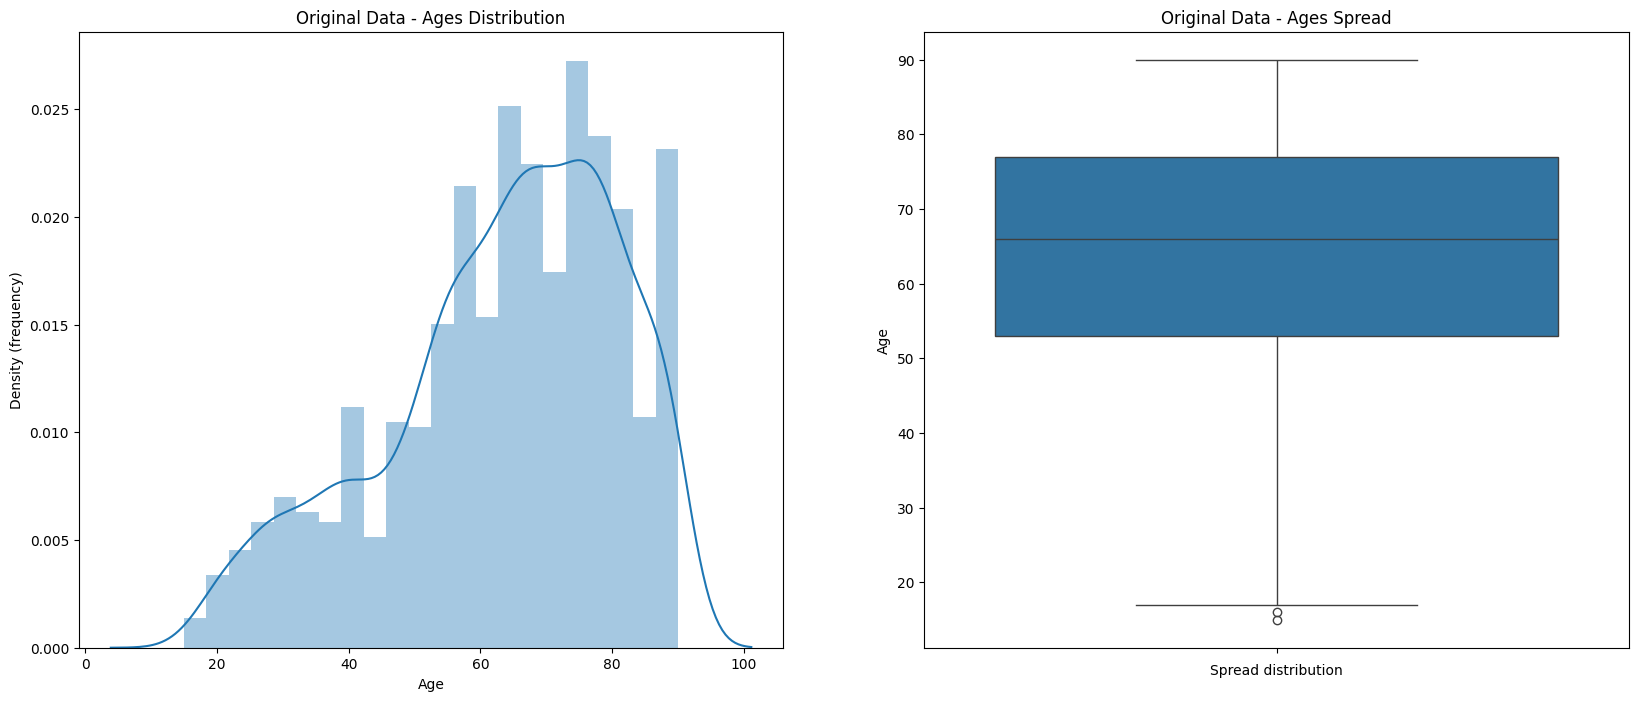

In [14]:
# We creating two plots, one with the distribution of our dataset and a second one with the spread of our dataset
# As we can see the majority of the ages are between 55 - 80 ages, and the mean is about 63 years old
# We don't have a lot data for the youngest ages, 15-20
# We don't have a lot data for the ages 20-40
# And we have a lot of data for the ages close to 90
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Original Data - Ages Distribution')
plt.ylabel('Density (frequency)')
sns.distplot(originalData.age)
plt.xlabel('Age')

plt.subplot(1,2,2)
plt.title('Original Data - Ages Spread')
plt.ylabel('Age')
plt.xlabel('Spread distribution')
sns.boxplot(y=originalData.age)

plt.show()

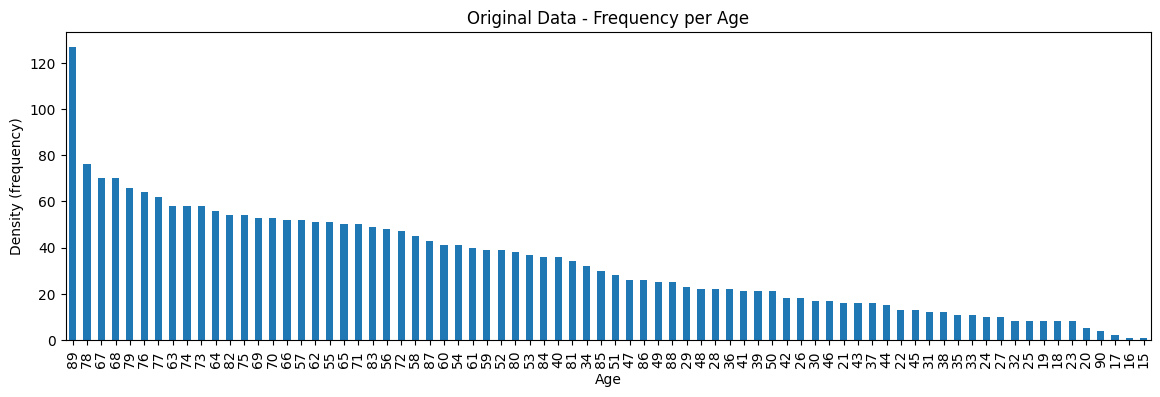

In [15]:
#Histogram with the ammount for each age
#as we can see, the previous plots can be verified
#the majority of our data are between the ages 55-80 years old,
#dataset consists of a lot of examples from 89 years old ages
#and doesnt contain a lof of information for the other ages 15-50
plt.figure(figsize=(14,4))
originalData['age'].value_counts().head(90).plot(kind='bar', color='#1f77b4')
plt.title('Original Data - Frequency per Age')
plt.xlabel('Age')
plt.ylabel('Density (frequency)')
plt.show()

# Step 3: Data scaling and model training
1. Scaling our data to balance the impact of all variable
2. Creating the generator, discriminator, combination, training

In [16]:
#We need to scale our data to balance the impact of the variables, a significal step for NNs
#Because the dataset does not have outliers values we can use MinMaxScaler for -1, 1
#mimmaxscaler linearily scales them down into a fixed range, where the largest occuring data point corresponds to the maximum value 
#and the smallest one corresponds to the minimum value.
scaler = MinMaxScaler(feature_range=(-1, 1))
originalData = scaler.fit_transform(originalData)

In [17]:
documentTraining = open("./ganTraining.txt", "w")
documentTraining.write("Epochs\tDiscriminatorLoss\tGeneratorLoss\n")
checkpoint_path = "./modelTraining/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [18]:
class Gan():

    #load data and epoch
    def __init__(self, data):
        self.data = data
        self.epochs = 1000

    
    # Generate random noise
    def noise(self):
        #generate random data according to the data.shape
        noise = numpy.random.normal(0, 1, self.data.shape)

        return noise

    
    #Generator:is a neural network that takes a random noise as input and generates fake data values.
    def generator(self):
        ''' 
        Creation of generator model with sequential, means that the model will consists of a stack of 
        dense layers, specifically three. Each layer consists of an activation function, ReLU. ReLU converts the
        output from 0 to infinity,. At the output layer activation tanh is used, because generator includes random data its values 
        lies between -1 to 1 
        '''
        model = tensorflow.keras.Sequential(name="Generator")
        model.add(tensorflow.keras.layers.Dense(32, input_dim=self.data.shape[1]))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(16))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(8))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(self.data.shape[1], activation='tanh'))
        # Display the model's architecture
        #model.summary()
        
        return model

    
    #Discriminator:is a neural network that takes a sample of either real or generated data
    #as input and outputs a scalar indicating the probability that the sample is real. 
    #In this code, the discriminator model is also defined using the Sequential class from TensorFlow and consists of 
    #two dense layers with ReLU activation, followed by a single dense layer with a sigmoid activation.
    def discriminator(self):
        '''
        Discriminator consists of four dense layers and the output layer uses sigmoid function
        because the original data charactirized as 1 and fake-generated as 0.
        '''
        model = tensorflow.keras.Sequential(name="Discriminator")
        model.add(tensorflow.keras.layers.Dense(16, input_dim=self.data.shape[1]))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(8))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(4))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(2))
        model.add(tensorflow.keras.layers.ReLU())
        model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))
        optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
        #Compile defines loss function, optimizer and  metrics of the discriminator model. 
        #Metric accuracy is used for the classification of originalData=1 and generatedData=0
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        # Display the model's architecture
        #model.summary()
        
        return model

    
    #SimpliestGan: is the model that compined generator and discriminator and is used for the training of the generator
    def simpliestGAN(self, generator, discriminator):
        '''
        Generator is trainable an discriminator untrainable. With this process the weights of the discriminator 
        frozen during the training to prevent the generator from adjusting its parameters in response to the discriminator's  
        feedback. So, generator is forced to produce more realistic samples
        '''
        discriminator.trainable = False
        generator.trainable = True
        model = tensorflow.keras.Sequential()
        model.add(generator)
        model.add(discriminator)
        #Optimizer Adam its more stable and faster to find local minimum vs classic gradient descent. 
        #Because update learning rate according to the batch size
        optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer)
        model.save("ganModel.keras")
        
        return model

    
    #Based on the epoch for loop, discriminator and the generator are trained alternately. 
    #In each epoch, the discriminator is trained on a batch of real and generated data using
    def train(self, generator, discriminator, gan):
        #create tables to save discriminator, and generator loss in order to create a loss plot
        epochs=self.epochs
        generatorLossHistory = []
        discriminatorLossHistory = []
        for epoch in range(self.epochs):
            # Generates predictions for the input samples from a data generator
            generatedData = generator.predict(self.noise())
            #Vector indicatates each sample is real or generated-fake.
            realGeneratedIndicator = numpy.concatenate([numpy.ones(self.data.shape[0]), numpy.zeros(self.data.shape[0])])
            realGeneratedData = numpy.concatenate([self.data, generatedData])
            discriminator.trainable = True
            #generator.trainable= False
            discriminatorLoss , _ = discriminator.train_on_batch(realGeneratedData, realGeneratedIndicator)*multiGPUs.num_replicas_in_sync
            noise = self.noise()
            #discriminator.trainable = False
            #generator.trainable= True
            generatorLoss = gan.train_on_batch(noise, numpy.ones(self.data.shape[0]))*multiGPUs.num_replicas_in_sync
            generatorLossHistory.append(generatorLoss)
            discriminatorLossHistory.append(discriminatorLoss)
            print('epochs=%d | discriminatorLoss=%.3f | generatorLoss=%.3f' %(epoch+1, discriminatorLoss, generatorLoss))
            documentTraining.write(str(epoch)+"\t"+str(discriminatorLoss)+"\t"+str(generatorLoss)+"\n")
        documentTraining.close()
        #Discriminator and generator loss history
        plt.figure(figsize=(8,6))
        plt.plot(discriminatorLossHistory, label='Discriminator loss')
        plt.plot(generatorLossHistory, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return generator

79/79 [==============================] - 0s 1ms/step


2023-11-10 12:38:19.789577: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-10 12:38:20.939710: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f72c403a870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-10 12:38:20.939733: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2023-11-10 12:38:20.944535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-10 12:38:20.958997: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-10 12:38:21.039500: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


epochs=1 | discriminatorLoss=0.688 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=2 | discriminatorLoss=0.688 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=3 | discriminatorLoss=0.688 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=4 | discriminatorLoss=0.688 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=5 | discriminatorLoss=0.688 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=6 | discriminatorLoss=0.688 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=7 | discriminatorLoss=0.687 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=8 | discriminatorLoss=0.687 | generatorLoss=0.693
79/79 [==============================] - 0s 978us/step
epochs=9 | discriminatorLoss=0.687 | generatorLoss=0.693
79/79 [==============================] - 0s 1ms/step
epochs=1

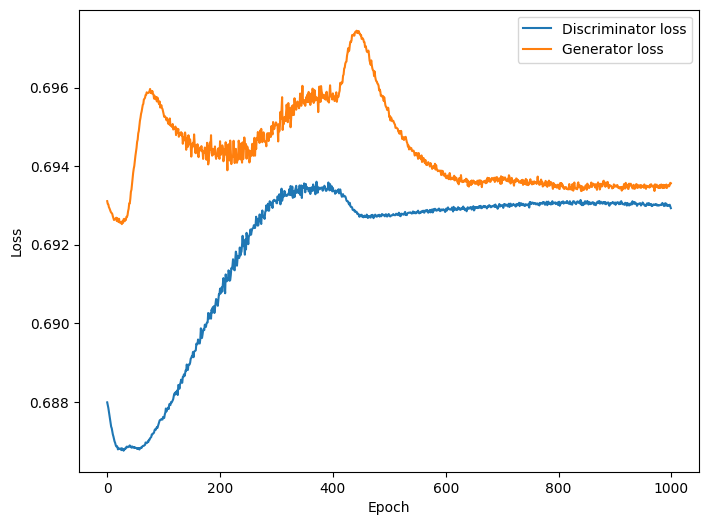

In [19]:
#Calling the functions
with multiGPUs.scope():
    model = Gan(data=originalData)
generator = model.generator()
descriminator = model.discriminator()
ganModel = model.simpliestGAN(generator=generator, discriminator=descriminator)
trainedModel = model.train(generator=generator, discriminator=descriminator, gan=ganModel)

In [20]:
#Generate new synthetic data through the generator
noise = numpy.random.normal(0, 1, originalData.shape)
generatedData = trainedModel.predict(noise)

79/79 [==============================] - 0s 1ms/step


# Step 4: Comparison original and generated data
1. Comparison of the distribution between the original and generated data for scaled and invert vectors through:
   scatter, histogram, distribution and box plot

In [21]:
#Convert original and generated data to panda from npy
originalData= pandas.DataFrame(originalData)
generatedData = pandas.DataFrame(generatedData)

In [22]:
originalDataInvert=scaler.inverse_transform(originalData)
originalDataInvert = pandas.DataFrame(originalDataInvert)
generatedDataInvert=scaler.inverse_transform(generatedData)
generatedDataInvert = pandas.DataFrame(generatedDataInvert)

In [23]:
#rename column to age
originalDataInvert=originalDataInvert.rename(columns={0: "age"})
generatedDataInvert=generatedDataInvert.rename(columns={0: "age"})

/tmp/ipykernel_106285/565473869.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(originalDataInvert.age)


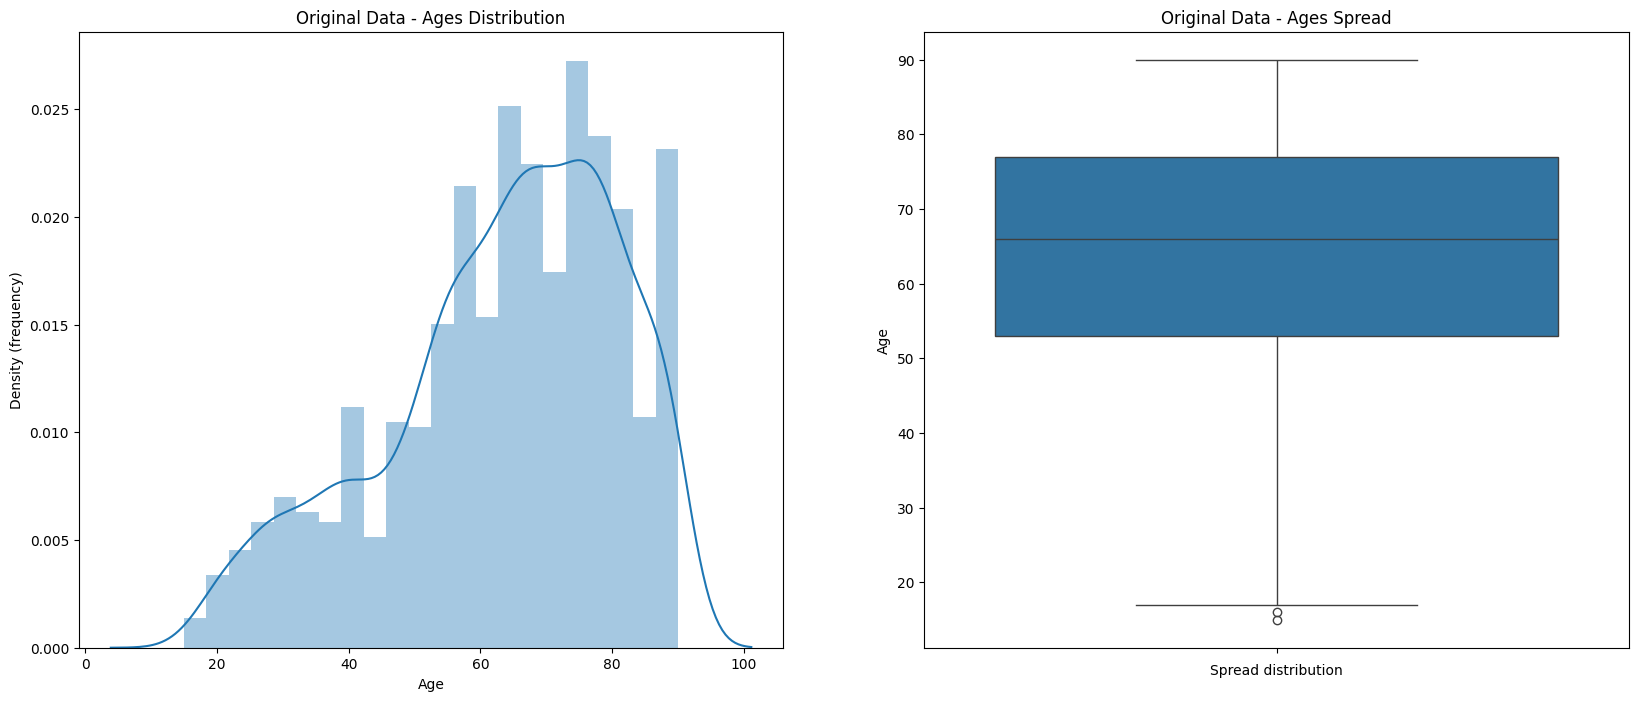

In [24]:
# We creating two plots, one with the distribution of our dataset and a second one with the spread of our dataset
# As we can see the majority of the ages are between 55 - 80 ages, and the mean is about 63 years old
# We don't have a lot data for the youngest ages, 15-20
# We don't have a lot data for the ages 20-40
# And we have a lot of data for the ages close to 90
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Original Data - Ages Distribution')
plt.ylabel('Density (frequency)')
sns.distplot(originalDataInvert.age)
plt.xlabel('Age')

plt.subplot(1,2,2)
plt.title('Original Data - Ages Spread')
plt.ylabel('Age')
plt.xlabel('Spread distribution')
sns.boxplot(y=originalDataInvert.age)

plt.show()

/tmp/ipykernel_106285/3890124255.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generatedDataInvert.age)


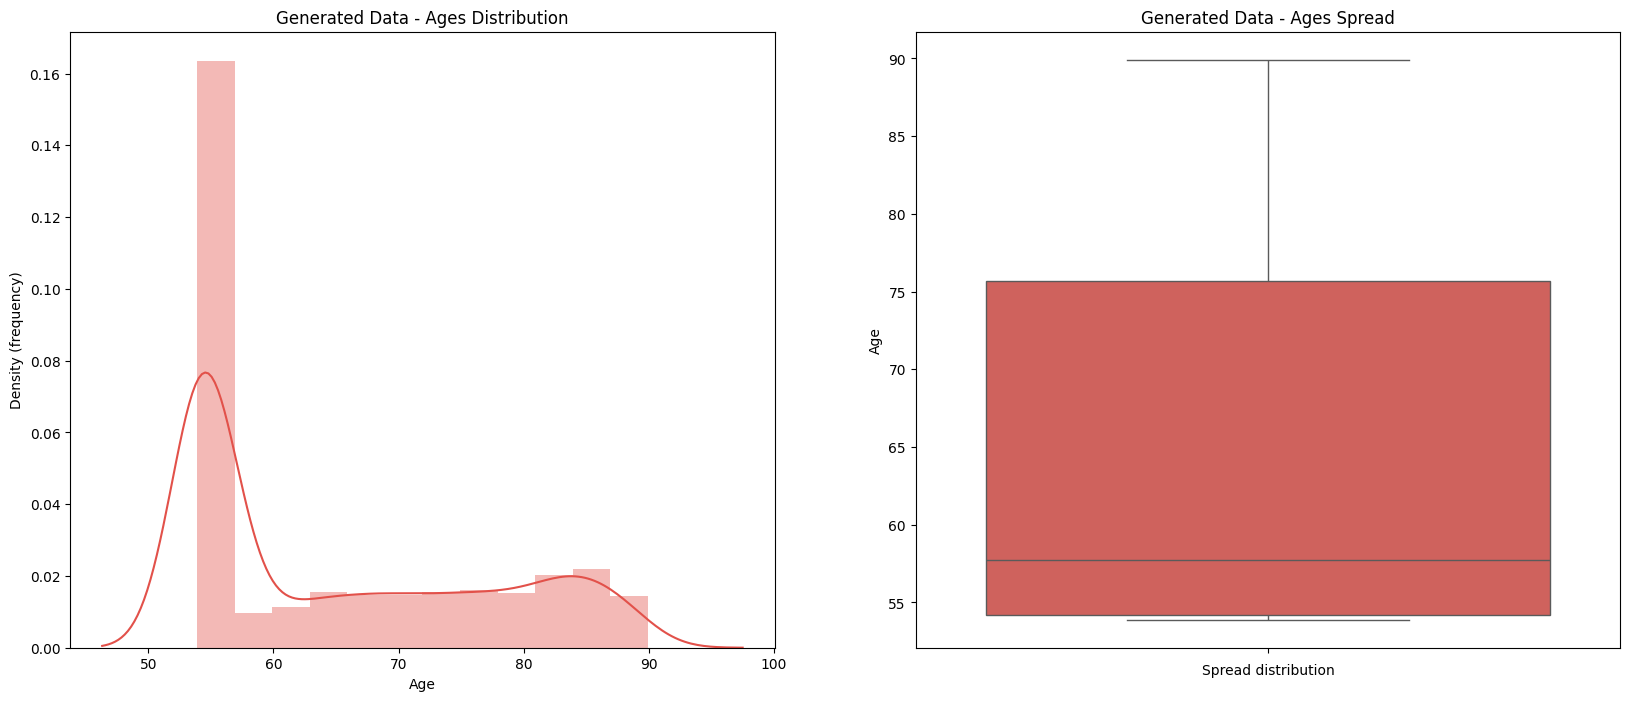

In [25]:
#Distribution and Boxplot for the generated data
#As we can observe the model can generate new synthetic data close to the original
#with a lack of the youngest ages 20-60
plt.figure(figsize=(20,8))
sns.set_palette("Spectral")
plt.subplot(1,2,1)
plt.title('Generated Data - Ages Distribution')
plt.ylabel('Density (frequency)')
sns.distplot(generatedDataInvert.age)
plt.xlabel('Age')

plt.subplot(1,2,2)
plt.title('Generated Data - Ages Spread')
plt.ylabel('Age')
plt.xlabel('Spread distribution')
sns.boxplot(y=generatedDataInvert.age)

plt.show()